In [2]:
from imutils.video import WebcamVideoStream
from imutils.video import FPS
import argparse
import imutils
import cv2
from datetime import datetime
import dlib
import serial
import time
import numpy as np

#inside retinaFace implementation, changed gpu from cuda to mps
from face_detection import RetinaFace
import torch
import torch.nn.functional as F
import sys
sys.path.append('sphereface_pytorch')
from net_sphere import sphere20a

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
#Loading sphereface model
device = torch.device("mps")
emb_model = sphere20a(feature=True)
emb_model.load_state_dict(torch.load("model/sphere20a_20171020.pth"))
emb_model = emb_model.to(device)

In [4]:
MEANS = [0.5, 0.5, 0.5]
STDS = [0.5, 0.5, 0.5]

emb_transform = A.Compose(
    [
        A.Normalize(MEANS, STDS),
        A.pytorch.ToTensorV2(),
    ]
)

In [5]:
#loading nic embeddings from txt file
nic_embeddings = np.loadtxt("nic_emb.txt", dtype=np.float32)
nic_embeddings.shape

(512,)

In [6]:
def align_image(img, bbox, keypoints, pad=15):
    x_min, y_min, x_max, y_max = bbox
    x_min = max(0, x_min - pad)
    y_min = max(0, y_min - pad)
    x_max = min(img.shape[1], x_max + pad)
    y_max = min(img.shape[0], y_max + pad)

    crop = A.Compose(
        [
            A.Crop(
                x_min=x_min,
                y_min=y_min,
                x_max=x_max,
                y_max=y_max,
            ),
            A.Resize(112, 96),
        ],
        keypoint_params=A.KeypointParams(format="xy"),
    )

    transformed = crop(image=img, keypoints=keypoints)
    keypoints = transformed["keypoints"]
    img_rgb = transformed["image"]

    return img_rgb

In [7]:
IMG_SIZE = (720, 400)


# Specify the serial port your Arduino is connected to
arduino_port = (
    "/dev/cu.usbmodem21201"  # Change this to your port (e.g., 'COM3' on Windows)
)

# Establish serial communication
#ser = serial.Serial(arduino_port, 2000000, timeout=1)

https://github.com/elliottzheng/face-detection

In [8]:
def send_coordinates(x, y):
    x = round(x, 3)
    y = round(y, 3)
    data = f"{x},{y}\n"
    ser.write(data.encode("utf-8"))
    print(data)


display = 2
num_frames = 0
send_every = 3  # send coordinates every n frames

# created a *threaded* video stream, allow the camera sensor to warmup,
# and start the FPS counter
print("[INFO] sampling THREADED frames from webcam...")
vs = WebcamVideoStream(src=0).start()
detector = RetinaFace(100)

# loop over some frames...this time using the threaded stream
start = datetime.now()
while True:
    # grab the frame from the threaded video stream and resize it
    # to have a maximum width of 400 pixels
    frame = vs.read()
    frame = cv2.resize(frame, dsize=IMG_SIZE)
    # check to see if the frame should be displayed to our screen
    frame = cv2.flip(frame, 1)
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # img_rgb = cv2.flip(img_rgb, 0)

    # detect face
    pred = detector(img_rgb)
    if len(pred) == 0:
        continue

    for f in pred:
        if f[2] < 0.7:
            continue
        xmin, ymin, xmax, ymax = np.int32(f[0])
        
        bbox = (xmin, ymin, xmax, ymax)
        # keypoints = f[1]
        keypoints = [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]

        xcenter = (xmin + xmax) / 2 / IMG_SIZE[0]
        ycenter = (ymin + ymax) / 2 / IMG_SIZE[1]
        # send_coordinates(xcenter, ycenter) #to modify with multiple faces detection

        # plot bbox with a text
        cv2.rectangle(
            frame, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2
        )

        # align face

        face = align_image(img_rgb, bbox, keypoints)
        face_tensor = emb_transform(image=face)["image"].unsqueeze(0).to(device)
        emb = emb_model(face_tensor).detach().cpu().numpy()[0]

        sim = F.cosine_similarity(
            torch.tensor(emb), torch.tensor(nic_embeddings), dim=-1
        )

        cv2.putText(
            frame,
            f"Sim: {sim.item():.2f}",
            org=(int(xmin), int(ymin) - 10),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.5,
            color=(0, 255, 0),
            thickness=1,
        )

    if display > 0:
        if num_frames > 0:
            fps_str = (
                f"FPS: {num_frames / (datetime.now() - start).total_seconds():.2f}"
            )
            # print(type(fps_str))
            cv2.putText(
                frame,
                fps_str,
                org=(10, 30),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1,
                color=(0, 255, 0),
                thickness=1,
            )

        cv2.imshow("Frame", frame)
        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):
            break
        # update the FPS counter
        num_frames += 1
        if num_frames == 20:
            num_frames = 0
            start = datetime.now()

cv2.destroyAllWindows()
vs.stop()
# ser.close()

[INFO] sampling THREADED frames from webcam...


In [4]:
def moving_average_filter(data, window_size=3):
    """
    Apply a simple moving average filter to the input data.

    Parameters:
    - data: Input data (list or numpy array).
    - window_size: Size of the moving average window.

    Returns:
    - smoothed_data: Data after applying the moving average filter.
    """
    weights = np.ones(window_size) / window_size
    smoothed_data = np.convolve(data, weights, mode='valid')
    return smoothed_data

def send_coordinates(x, y):
    # Send x and y coordinates to the robotic arm
    data = f"{x} {y}\n"
    ser.write(data.encode())

# Example usage:
x_coordinates = [377, 373, 360, 350]
y_coordinates = [541, 524, 523]

# Apply a moving average filter to the coordinates
window_size = 3
smoothed_x = moving_average_filter(x_coordinates, window_size)
smoothed_y = moving_average_filter(y_coordinates, window_size)

smoothed_x

array([370., 361.])

In [22]:
import matplotlib.pyplot as plt
vs = WebcamVideoStream(src=0).start()

frame = vs.read()
frame = imutils.resize(frame)
# check to see if the frame should be displayed to our screen
frame = cv2.flip(frame, 1)
img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
img_rgb = np.array(img_rgb)

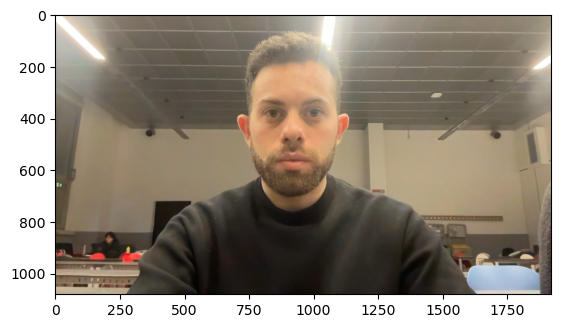

In [23]:
plt.imshow(img_rgb)

In [24]:
detector = RetinaFace(0)
detector(img_rgb)

[(array([ 747.2467,  203.4431, 1104.7767,  669.5704], dtype=float32),
  array([[ 842.8102 ,  376.1249 ],
         [1005.97986,  379.70978],
         [ 921.5766 ,  475.89398],
         [ 858.10144,  556.8547 ],
         [ 985.8461 ,  559.7658 ]], dtype=float32),
  0.9995338),
 (array([197.75534, 853.0762 , 222.00156, 883.58246], dtype=float32),
  array([[200.90718, 864.64954],
         [209.49907, 864.3379 ],
         [202.8295 , 871.8586 ],
         [203.50735, 877.32416],
         [209.74704, 876.96075]], dtype=float32),
  0.1484411),
 (array([738.05554, 112.7515 , 824.59485, 230.81525], dtype=float32),
  array([[760.60846, 140.7469 ],
         [770.13446, 144.466  ],
         [743.07886, 151.84998],
         [745.5089 , 186.21292],
         [751.3568 , 188.80815]], dtype=float32),
  0.12353641),
 (array([742.34845, 140.72604, 789.6754 , 215.36888], dtype=float32),
  array([[756.0694 , 156.26822],
         [761.32544, 160.88387],
         [744.0367 , 168.8164 ],
         [746.33295, 1

In [25]:
KEYPOINT_COLOR = (0, 255, 0) # Green

def vis_keypoints(image, keypoints, color=KEYPOINT_COLOR, diameter=2):
    image = image.copy()

    for (x, y) in keypoints:
        cv2.circle(image, (int(x), int(y)), diameter, color, -1)
        
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(image)

In [26]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

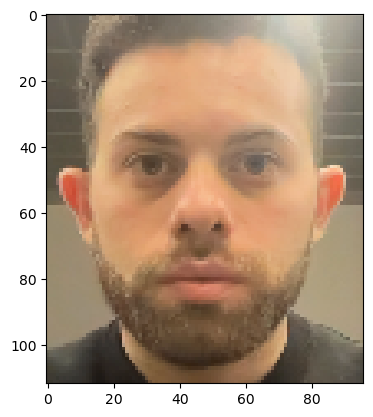

In [34]:
pred = detector(img_rgb)[0]
bbox = np.array(pred[0], dtype=np.int32)
keypoints = np.array(pred[1])
aligned = align_image(img_rgb, bbox, keypoints, pad = 60)
plt.imshow(aligned)

In [255]:
#!git clone https://github.com/clcarwin/sphereface_pytorch.git

In [256]:
import sys
sys.path.append('sphereface_pytorch')

In [257]:
from net_sphere import sphere20a

device = torch.device("mps")
emb_model = sphere20a(feature=True)
emb_model.load_state_dict(torch.load("model/sphere20a_20171020.pth"))
emb_model = emb_model.to(device)

In [259]:
MEANS = [0.5, 0.5, 0.5]
STDS = [0.5, 0.5, 0.5]

emb_transform = A.Compose(
    [
        A.Normalize(MEANS, STDS),
        A.pytorch.ToTensorV2(),
    ]
)

aligned = emb_transform(image=aligned)["image"].unsqueeze(0).to(device)
aligned.shape

torch.Size([1, 3, 112, 96])

In [263]:
nic_emb = emb_model(aligned)[0]
#save nic_emb to a txt file
np.savetxt("nic_emb.txt", nic_emb.cpu().detach().numpy())